In [5]:
import matplotlib as plt
import textwrap

In [6]:
import sys
sys.path.append('..')
from utils import *

In [7]:
# arxiv_number_list=['1106.6060','1812.04213','2004.04168','2008.08998','2012.04554','2108.02159','2110.11330','2111.01152','2112.07523',]
arxiv_number_list = [
    "1010.1819",
    "1106.6060",
    "1208.0116",
    # "1212.5363", # TODO
    "1310.2674",
    "1812.04213",
    "2004.04168",
    "2008.08998",
    "2012.04554",
    "2108.02159",
    "2110.11330",
    "2111.01152",
    "2112.07523",
    "2308.03843",
    "2308.07488",
]
# '2308.03843'

In [3]:
len(set(arxiv_number_list))

14

In [94]:
import pandas as pd

In [133]:
def load_arxiv(arxiv_number):
    # Load arxiv and convert to dict
    prompt_template='../prompt_template.md'
    prompt_dict=load_prompt_template(prompt_template)
    with open(os.path.join('..',f'{arxiv_number}',f'{arxiv_number}.yaml'),'r') as f:
        kwargs= yaml.safe_load(f)
    tasks = [f'Task:{idx+1} '+kwarg['task'] for idx,kwarg in enumerate(kwargs[1:])]
    score_dict={}
    for kwarg in kwargs[1:]:
        for key,value in (list(kwarg['score'].items())):
            assert isinstance(value, int), f'{arxiv_number}/{kwarg["task"]}:{key}:{value} is not int'
            if key not in score_dict:
                score_dict[key]=[value]
            else:
                score_dict[key].append(value)
    
    return pd.DataFrame(score_dict,index=tasks)

In [142]:
arxiv_dict_list={arxiv_number:load_arxiv(arxiv_number) for arxiv_number in arxiv_number_list}
arxiv_dict=pd.concat(arxiv_dict_list.values(),keys=arxiv_dict_list.keys(),names=['arxiv_number','task'])

In [89]:
import matplotlib.pyplot as plt
import numpy as np

def plot_single_file(score_dict):
    x = np.arange(len(score_dict['task']))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained',figsize=(8,5))
    color_list=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)]
    for attribute, measurement in score_dict['score'].items():
        offset = width * multiplier
        rects = ax.barh(x + offset, np.array(measurement)+0.1, width, label=attribute,color=color_list[multiplier],left=-0.1)
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xlabel('Score')
    ax.set_xticks([0,1,2])
    ax.set_title(f"{score_dict['arxiv']} [mean={np.mean(score_dict['score']['final_answer_accuracy']):.2f}]")
    ax.set_yticks(x + width*4, ['\n'.join(textwrap.wrap(task, width=40)) for task in score_dict['task']],fontsize=8)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1))

    ax.grid(axis='x',ls='--')
    # ax.set_ylim(0, 250)
    ax.set_xlim(-0.1,2.1)


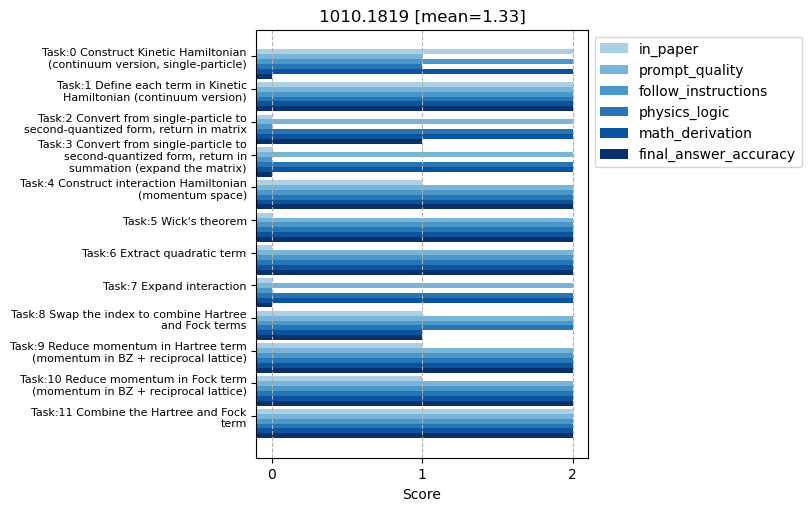

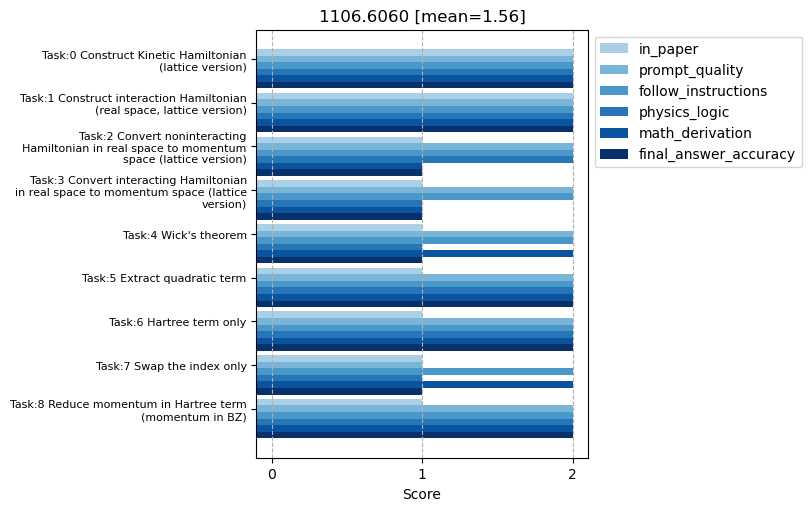

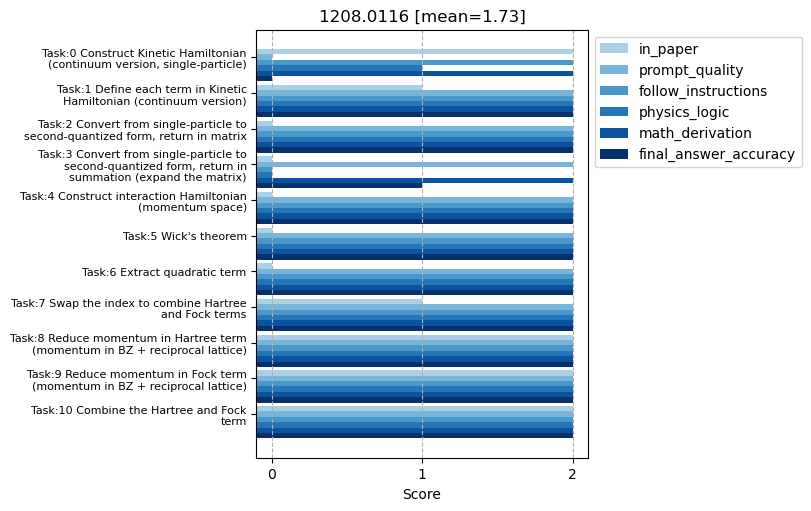

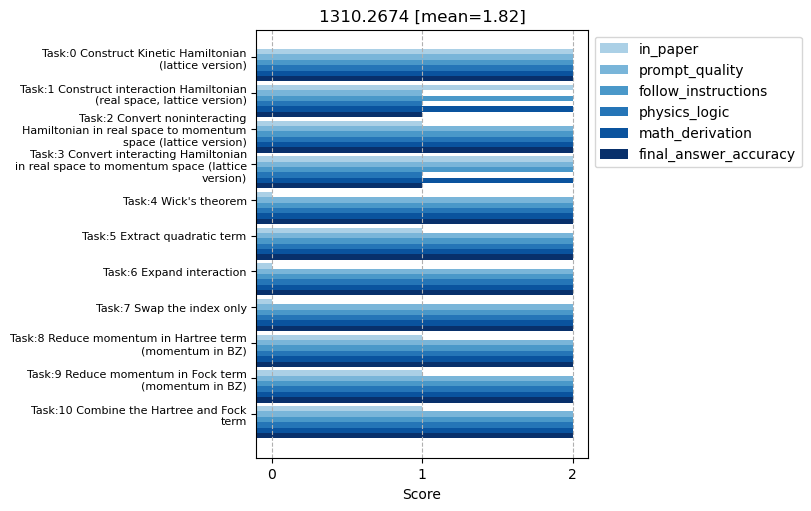

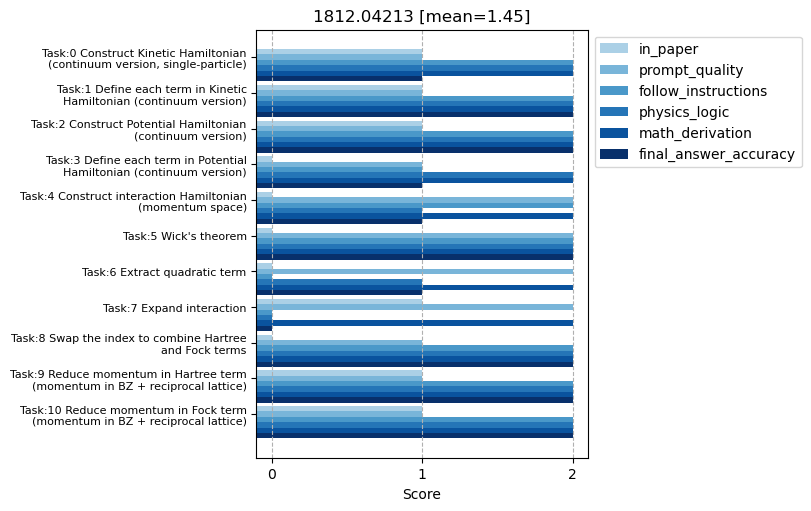

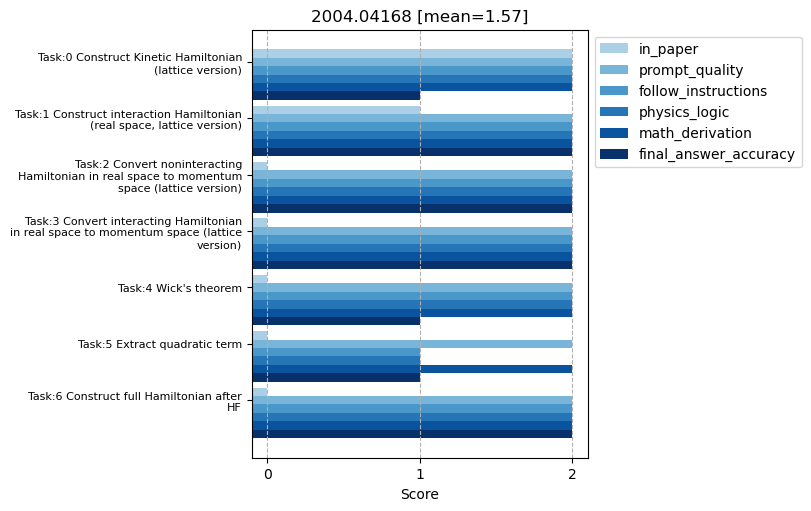

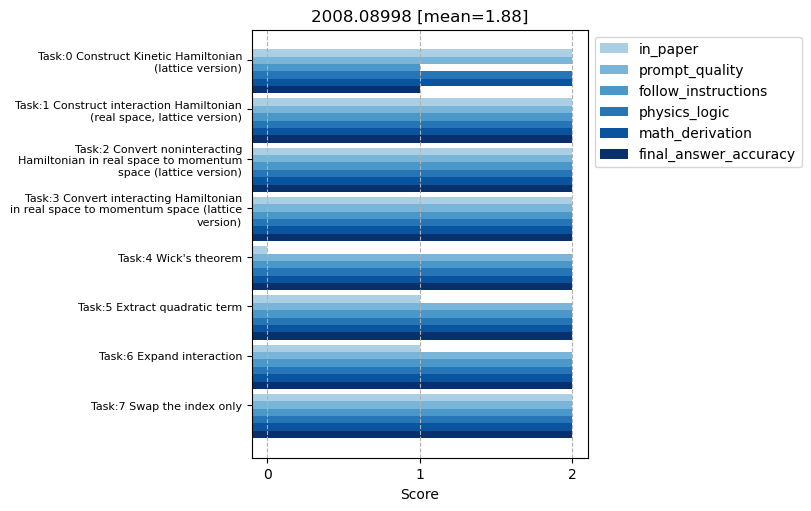

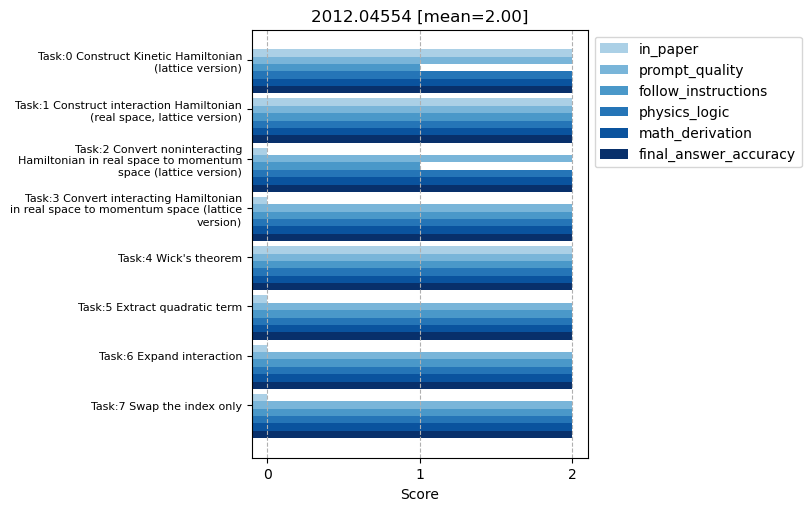

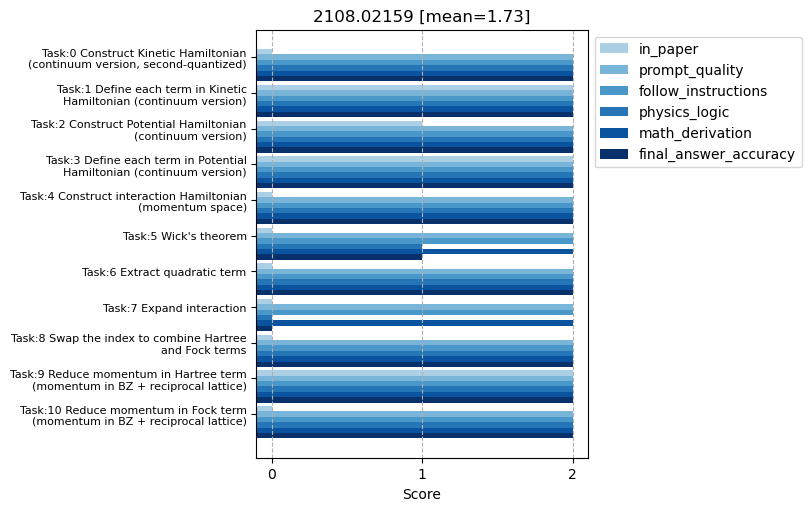

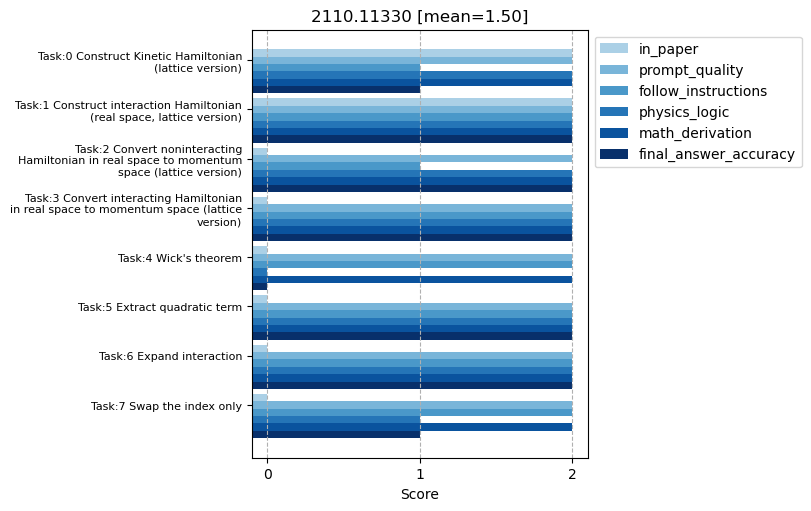

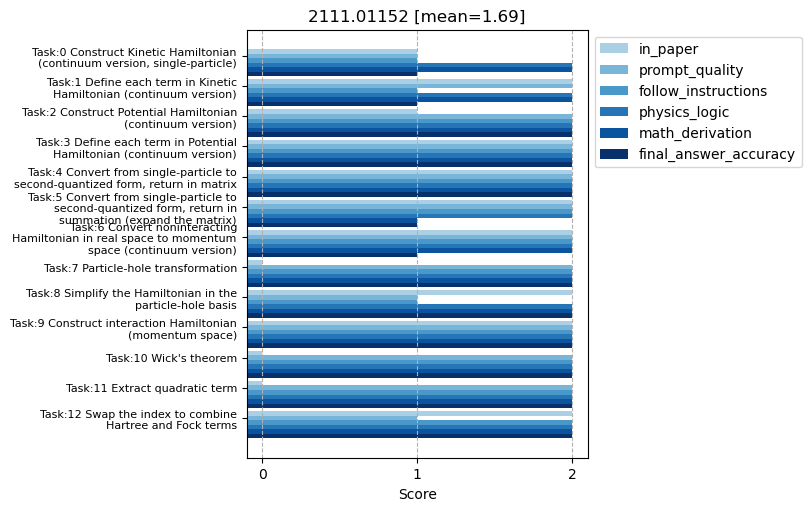

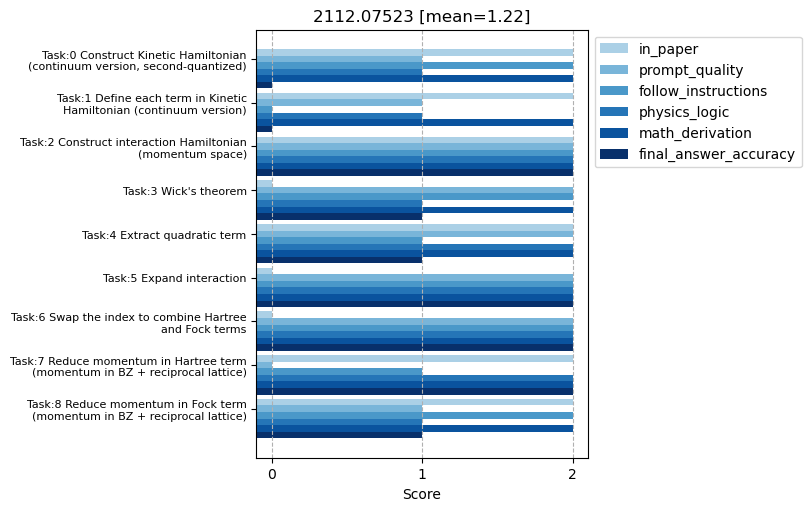

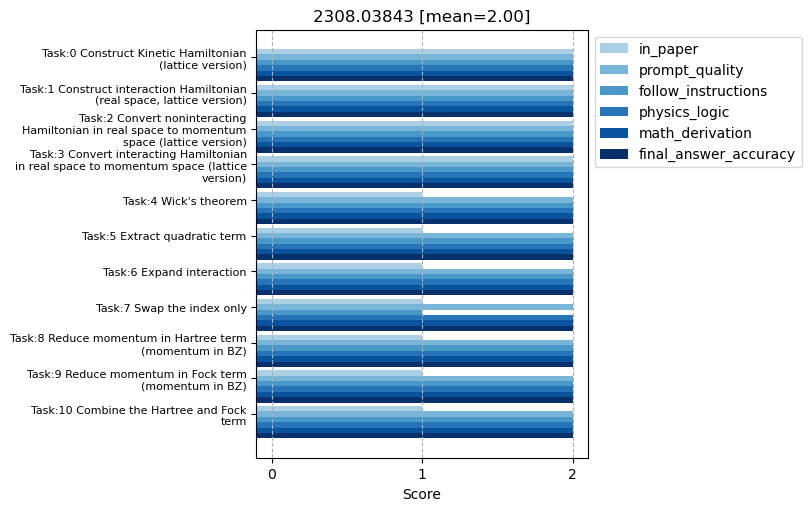

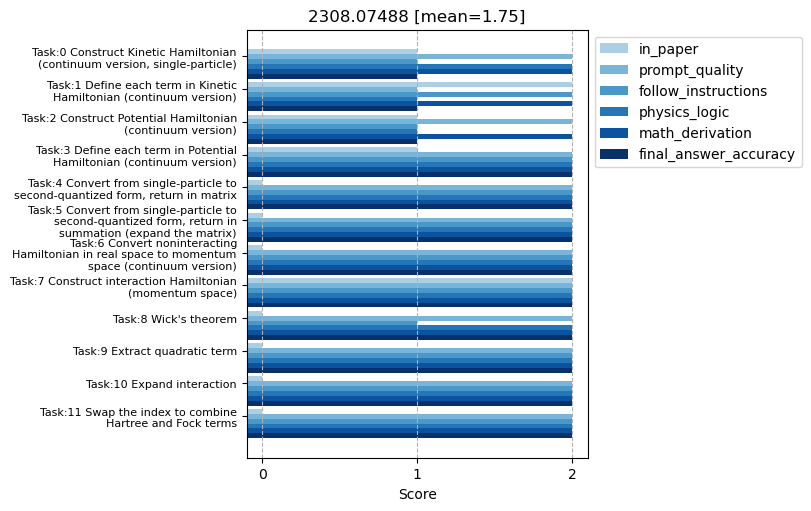

In [90]:
for score_dict in score_dict_list:
    plot_single_file(score_dict)

In [223]:
arxiv_dict_mean=arxiv_dict.groupby('arxiv_number')[['final_answer_accuracy']].mean()
arxiv_dict_se=arxiv_dict.groupby('arxiv_number')[['final_answer_accuracy']].sem()

In [147]:
import pickle

In [150]:
with open('reading_data.pickle','rb') as f:
    reading_data=pickle.load(f)

In [221]:
reading_data_mean=reading_data.xs(key='Haining',level='scorer').groupby('arxiv').mean()
reading_data_se=reading_data.xs(key='Haining',level='scorer').groupby('arxiv').sem()

In [222]:
reading_data_mean

,Value
arxiv,
1010.1819,1.098361
1106.6060,0.750000
1208.0116,1.375000
1310.2674,1.163265
1812.04213,1.101695
2004.04168,0.611111
2008.08998,1.522727
2012.04554,1.022727
2108.02159,1.180328


In [193]:
pd.concat([arxiv_dict_group,reading_data_sort],axis=1,).rename(columns={'final_answer_accuracy':'execution','Value':'reading'})

,execution,reading
1010.1819,1.333333,1.098361
1106.6060,1.555556,0.750000
1208.0116,1.727273,1.375000
1310.2674,1.818182,1.163265
1812.04213,1.454545,1.101695
2004.04168,1.571429,0.611111
2008.08998,1.875000,1.522727
2012.04554,2.000000,1.022727
2108.02159,1.727273,1.180328
2110.11330,1.500000,1.181818


Text(0.5, 1.0, 'Correlation:-0.0347')

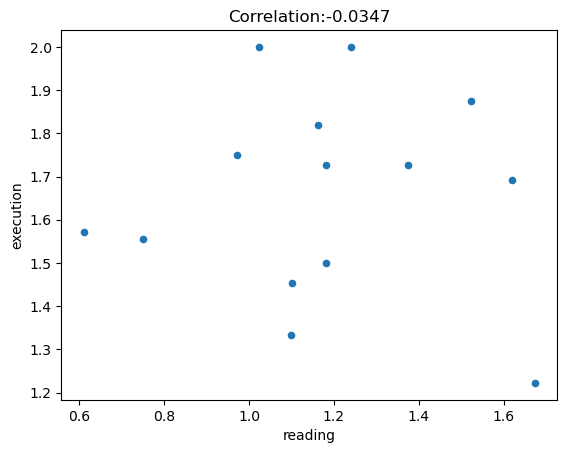

In [274]:
execution_reading_mean.plot(kind='scatter',x='reading',y='execution')
plt.title(f'Correlation:{execution_reading_mean.corr().loc["reading","execution"]:0.04f}')

array([1.65908001, 1.17938433])

In [239]:
execution_reading_se.mean()

execution    0.163358
reading      0.122185
dtype: float64

Text(0.5, 0, 'Score')

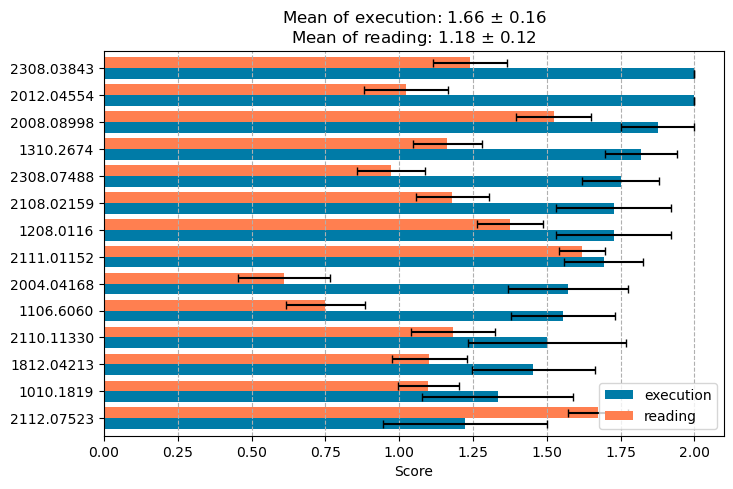

In [256]:
execution_reading_mean=pd.concat([arxiv_dict_mean,reading_data_mean],axis=1,).rename(columns={'final_answer_accuracy':'execution','Value':'reading'}).sort_values('execution')
execution_reading_se=pd.concat([arxiv_dict_se,reading_data_se],axis=1,).rename(columns={'final_answer_accuracy':'execution','Value':'reading'}).sort_values('execution')

execution_reading_mean.plot(kind='barh',color=['#007BA7', '#FF7F50'],figsize=(8,5),width=0.8,xerr=execution_reading_se,capsize=3)
plt.title('\n'.join([f'Mean of {kind}: {mean:.2f} $\pm$ {se:.2f}' for kind,mean,se in zip(['execution','reading'],execution_reading_mean.mean(),execution_reading_se.mean())]))
plt.grid(axis='x',ls='--')
plt.xlabel('Score')

In [ ]:
color_list=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)]

Text(0.5, 0, 'Score')

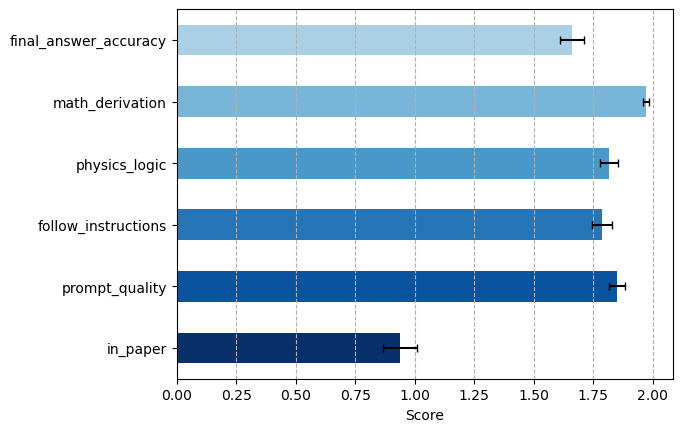

In [255]:
arxiv_dict.mean().plot(kind='barh',color=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)],xerr=arxiv_dict.sem(),capsize=3,)
plt.grid(axis='x',ls='--')
plt.xlabel('Score')

In [29]:
import pandas as pd

In [30]:
def load_score(arxiv_number):
    prompt_template='../prompt_template.md'
    # arxiv_number='1106.6060'
    prompt_dict=load_prompt_template(prompt_template)
    with open(os.path.join('..',f'{arxiv_number}',f'{arxiv_number}.yaml'),'r') as f:
        kwargs= yaml.safe_load(f)
    tasks=[f'Task:{idx} '+kwarg['task'] for idx,kwarg in enumerate(kwargs[1:])]
    aspect_score={}
    for kwarg in kwargs[1:]:
        for key,value in (list(kwarg['score'].items())):
            if key not in aspect_score:
                aspect_score[key]=[value]
            else:
                aspect_score[key].append(value)
    return pd.DataFrame(aspect_score,index=tasks)

In [31]:
df_list=[load_score(arxiv_number) for arxiv_number in arxiv_number_list]

In [32]:
dfs=pd.concat(df_list,keys=arxiv_number_list,names=['arxiv_number','task'])

In [163]:
dfs

NameError: name 'dfs' is not defined

Text(0.5, 0, 'Score')

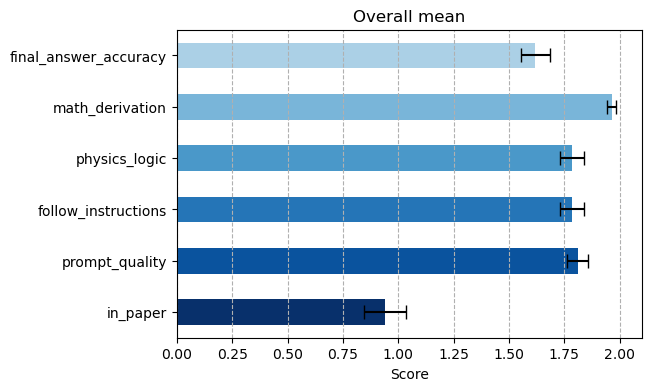

In [33]:
error_bar=dfs.std().values/dfs.shape[0]**0.5
dfs.mean().plot(kind='barh',figsize=(6,4),xlim=(0,2.1),title='Overall mean',color=color_list,xerr=error_bar,capsize=5)
plt.grid(axis='x',ls='--')
plt.xlabel('Score')

In [161]:
df.T

,Original Score,Conditional Score
Quality,8,7
Efficiency,6,5
Reliability,7,8
Innovation,9,8


In [264]:
group='in_paper'
# group='prompt_quality'
mean=arxiv_dict.groupby(group)[['follow_instructions','physics_logic','math_derivation','final_answer_accuracy']].mean()
error_bar=arxiv_dict.groupby(group)[['follow_instructions','physics_logic','math_derivation','final_answer_accuracy']].std()/arxiv_dict.groupby(group)[['follow_instructions','physics_logic','math_derivation','final_answer_accuracy']].count()**0.5


In [265]:
mean

,follow_instructions,physics_logic,math_derivation,final_answer_accuracy
in_paper,,,,
0,1.727273,1.781818,2.000000,1.672727
1,1.850000,1.850000,1.925000,1.725000
2,1.804348,1.826087,1.978261,1.586957


In [266]:
list(mean.iterrows())

[(0,
  follow_instructions      1.727273
  physics_logic            1.781818
  math_derivation          2.000000
  final_answer_accuracy    1.672727
  Name: 0, dtype: float64),
 (1,
  follow_instructions      1.850
  physics_logic            1.850
  math_derivation          1.925
  final_answer_accuracy    1.725
  Name: 1, dtype: float64),
 (2,
  follow_instructions      1.804348
  physics_logic            1.826087
  math_derivation          1.978261
  final_answer_accuracy    1.586957
  Name: 2, dtype: float64)]

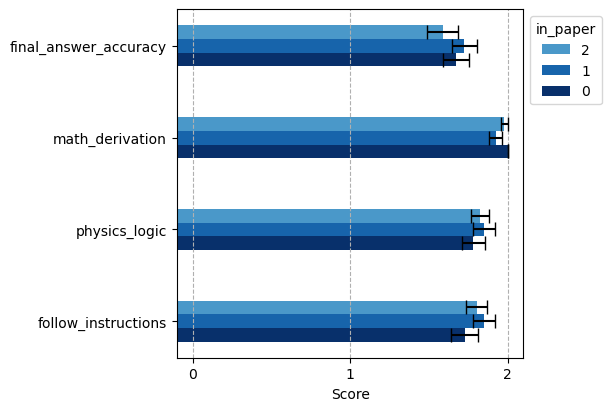

In [267]:
x = np.arange(mean.shape[1])  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(6,4))
color_list=[plt.cm.Blues(0.2+0.8*(i/4)) for i in range(4,0,-1)]
# for attribute, measurement in aspect_score.items():
for attribute, measurement in mean.iterrows():
    offset = width * multiplier
    if not error_bar.loc[attribute].isna().any():
        rects = ax.barh(x + offset, np.array(measurement)+0.1, width, label=attribute,color=color_list[multiplier],left=-0.1,xerr=error_bar.loc[attribute].values,capsize=5)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks([0,1,2])
# ax.set_title(f"{arxiv_number}")
ax.set_yticks(x + width*1, ['\n'.join(textwrap.wrap(label, width=40)) for label in mean.columns])

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1),title=group)

ax.grid(axis='x',ls='--')
# ax.set_ylim(0, 250)
ax.set_xlim(-0.1,2.1)

plt.show()